# Security Group Clustering

This code was used to assist in the migration from massive security group membership sprawl to RBAC (Role Based Access Control) in a large company's Active Directory domain. As made apparent using the provided sample data, the organization had a trend of having more unique security groups than users, and a large number of unique combinations of security groups. 

This method uses one-hot dummy encoding and K-Means clustering to find natural patterns within the users, and provide visualizations and metrics to determine the optimal number of groups to use. The Jupyter notebook was written with markup and HTML code to allow it to be exported to a PDF for review with key stakeholders.

Tools used:
- Isolation Forests
- MCA (Multiple Correspondence Analysis)
- K-Means Clustering

Other clustering algorithms were also tested, including: 
- OPTICS
- SpectralClustering
- AffinityPropagation
- DBSCAN

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score
import scipy.cluster.hierarchy as sch
from IPython.display import display, Markdown, HTML

warnings.simplefilter(action='ignore', category=FutureWarning)

plt.style.use('fivethirtyeight')

department = "Sample"

plt.style.use('fivethirtyeight')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'white'

In [2]:
# Run this before exporting HTML
printable = False
if printable:
    # Remove left padding from cells
    # Center images and tables
    display(HTML("""<style>.output_png {display: table-cell; text-align: center;}
    
                .dataframe {margin-left: auto !important; margin-right: auto !important;}
                .input_prompt {min-width: 0px !important; width:0px !important; visibility: hidden !important;}
                 .prompt {min-width: 0px !important; width:0px !important;}</style>"""))

In [3]:
filename = department + "Users.csv"
users = pd.read_csv(filename, skiprows=0)
orig_users = users.copy()
display(Markdown('\n# <center>{} Users Security Group Report</center>'.format(department)))
one_hot_c = users.Groups.str.get_dummies(sep=';')
group_cols = one_hot_c.columns
display(Markdown('**User Count: {} <br> Unique Security Groups: {}**'.format(len(users), len(group_cols))))
display(Markdown('### <center> First 5 User Records</center>'.format(department)))
display(orig_users.head())


# <center>Sample Users Security Group Report</center>

**User Count: 179 <br> Unique Security Groups: 214**

### <center> First 5 User Records</center>

,Unnamed: 0,UserName,Title,Groups
0,0,User 1,Role 20,Group 1;Group 14;Group 22;Group 28;Group 32;Gr...
1,1,User 2,Role 41,Group 1;Group 14;Group 43;Group 55;Group 56;Gr...
2,2,User 3,Role 23,Group 1;Group 14;Group 38;Group 43;Group 84;Gr...
3,3,User 4,Role 13,Group 1;Group 3;Group 14;Group 22;Group 33;Gro...
4,4,User 5,Role 25,Group 1;Group 14;Group 28;Group 43;Group 84;Gr...


In [5]:
users = pd.concat([users, one_hot_c], axis=1)
users['GroupCount'] = users[group_cols].sum(axis=1)
if len(users[users.GroupCount >= 100]) > 0:
    display(Markdown('\n### Users with more than 100 security groups'))
    display((Markdown('**User Count: {}**'.format(len(users[users.GroupCount >= 100])))))
    display((users[users.GroupCount >= 100])[['UserName', 'BillingCode', 'Title', 'GroupCount']])

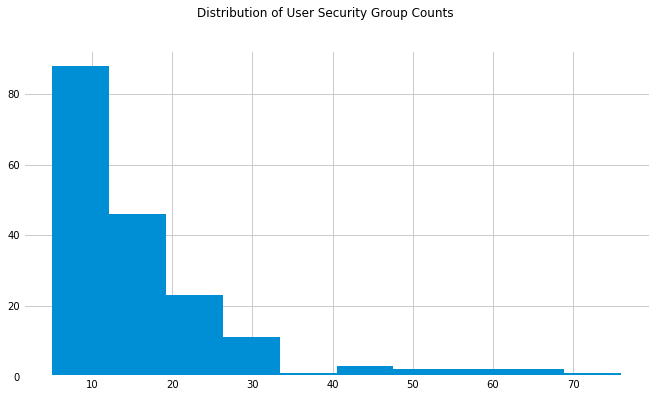

In [6]:
X = users[group_cols]
base_X = X.copy()
fig = plt.plot()
count_dist = users.GroupCount.hist(figsize=(10,6))
title = plt.suptitle("Distribution of User Security Group Counts")

In [7]:
def membership_accuracy(X, y):
    ratios = X.astype(int).groupby(y).mean()
    ratios[ratios == 0] = np.nan
    base_score = np.sqrt(((ratios**2).mean()).mean())
    return base_score, base_score - ((1-base_score)*(len(np.unique(y))/(len(X) - len(np.unique(y)) - 1))) * 2

# <center>Outliers</center>

,UserName,Title,Deviance
0,User 1,Role 20,-0.063741
8,User 9,Role 3,-0.164234
22,User 23,Role 13,-0.082830
50,User 51,Role 15,-0.148456
58,User 59,Role 2,-0.101881
65,User 66,Role 27,-0.051991
68,User 69,Role 17,-0.117798
107,User 108,Role 14,-0.142447
136,User 137,Role 13,-0.029384
176,User 177,Role 16,-0.035255


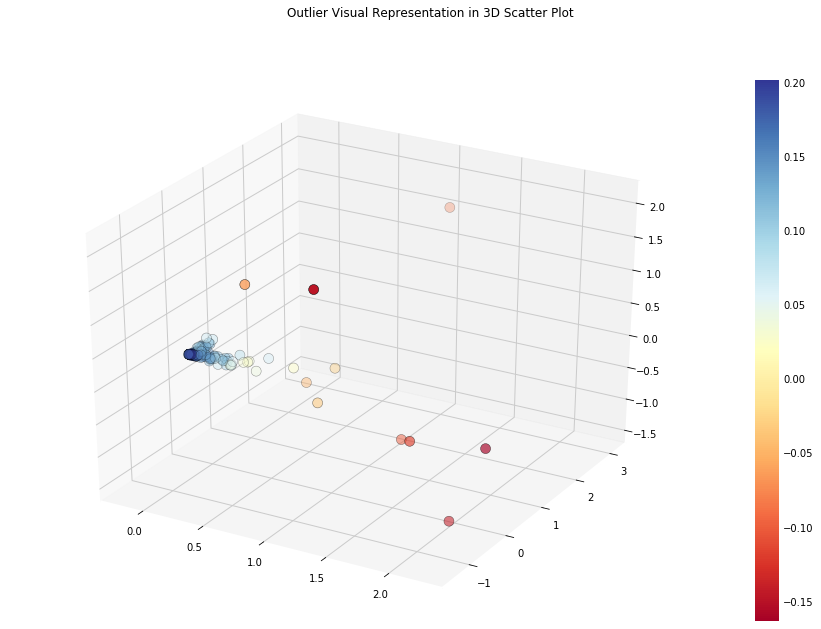

Explained Inertia: [0.13468673728563413, 0.08292727684366406, 0.07656452674476616]


*In order to graph the users in a 3D space, Multiple Correspondence Analysis is used to represent the users group memberships in a low dimensionality Euclidian space using 3 numerical components for each user. The explained inertia above represents the ratio of how much of the variance across the dataset that each component accounts for.*

In [9]:
# Display a graph for every outlier user?
display_outliers = False

from sklearn.ensemble import IsolationForest
import mpl_toolkits.mplot3d as Axes3D
import plotly.express as px
import pickle
from prince import MCA
from IPython.core.display import HTML
import plotly.offline as py

clf = IsolationForest(n_estimators=600, random_state=42, behaviour='new', contamination='auto', bootstrap=False)
X = base_X.copy()
outliers = clf.fit_predict(X)
deviance = clf.decision_function(X)
users['Deviance'] = deviance
display(Markdown('# <center>Outliers</center>'))
display(users[users.Deviance <= 0][['UserName', 'Title', 'Deviance']])

# Graph the outliers
mca = MCA(n_components=3)
mca_X = mca.fit_transform(X)
color_code = (deviance < 0)

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection='3d')
plot = ax.scatter(mca_X[:][0], mca_X[:][1], mca_X[:][2], c=deviance, cmap='RdYlBu', s=100, edgecolors='black')
plt.suptitle("Outlier Visual Representation in 3D Scatter Plot")
plt.colorbar(plot)
plt.show()
    
print("Explained Inertia:", mca.explained_inertia_)
display(Markdown('*In order to graph the users in a 3D space, Multiple Correspondence Analysis is used to '+\
                 'represent the users group memberships in a low dimensionality Euclidian space using 3 '+\
                 'numerical components for each user. The explained inertia above represents the ratio of '+\
                 'how much of the variance across the dataset that each component accounts for.*'))

if display_outliers:

    display(Markdown('\n## Individual Outlier Group Membership Ratios'))

    display(HTML('<div class="alert alert-block alert-info"><ul>'+\
                 '<li>The graphs below show the distribution of membership for the security groups that each '+\
                 'of the outliers are a member of. The percentage on the right side of each horizontal bar represents '+\
                 'the percentage of membership for that security group that the outlier user accounts for.</li>'+\
                 '<li>A user can be considered an outlier due to being a member of security groups that no one else '+\
                 'in the dataset is a member of, or based on the unique combination of security groups that differs '+\
                 'significantly from all other users in the dataset.</li></ul>'+\
                 '</div>'))

    outlier_users = users[users.Deviance <= 0]

    for index, user in outlier_users.iterrows():
        group_size=1
        outliers_populated_columns = group_cols[(user[group_cols] == 1)]
        group_dist = users.groupby(users.index.isin(user.index))[outliers_populated_columns].sum().transpose()
        group_dist[True] = user[outliers_populated_columns]

        outgroup_size = len(users) - 1
        group_stats = pd.DataFrame()

        group_stats['Outlier Member True'] = group_dist[True]
        group_stats['Std Member True'] = group_dist[False]
        group_stats['Std Member False'] = outgroup_size - group_dist[False]

        plot_size = len(outliers_populated_columns)
        group_stats = group_stats.sort_values('Outlier Member True')
        ax = group_stats.plot.barh(stacked=True, figsize=(10,plot_size*0.4), legend=False)
        patches, labels = ax.get_legend_handles_labels()
        legend = ax.legend(patches, labels, bbox_to_anchor=(-0.3, 1.001, 0.9, .102), loc=3, fancybox=True, ncol=4)

        for i, val in enumerate(group_stats['Outlier Member True']):
            ax.text(group_size+outgroup_size+3, i-0.2, "{0:.0%}".format(float(val/group_stats.iloc[i]['Std Member True'])))

        plt.show()

In [20]:
# Exclude outliers from data set?
exclude_outliers = True
threshold = -0.02

display(Markdown('**Total Users: {} <br> Exlude Outliers: {} <br>'.format(len(users), exclude_outliers,)+\
                 'Threshold: {} <br> Outliers: {} <br>Total if Outliers Exluded: {}**'.format(threshold,
                                                                                              len(users[users.Deviance <= threshold]), 
                                                                                              len(users[users.Deviance >= threshold]))))

**Total Users: 179 <br> Exlude Outliers: True <br>Threshold: -0.02 <br> Outliers: 10 <br>Total if Outliers Exluded: 169**


## User Clustering to Identify Best Number of Roles

### Metrics for Each Combination of Roles

Number of Roles: 6 MemAcc: 0.2980381694133848 Calinksi: 20.8299 Silhouette Score: 0.21205723135311993
Number of Roles: 7 MemAcc: 0.30027311528770245 Calinksi: 19.5687 Silhouette Score: 0.2284486875542186
Number of Roles: 8 MemAcc: 0.326961770565055 Calinksi: 18.5411 Silhouette Score: 0.23466914341233602
Number of Roles: 9 MemAcc: 0.3279037570570932 Calinksi: 17.5008 Silhouette Score: 0.24359746967568324
Number of Roles: 10 MemAcc: 0.37181690431947423 Calinksi: 17.2275 Silhouette Score: 0.25660193301174766
Number of Roles: 11 MemAcc: 0.3736349369396385 Calinksi: 16.8548 Silhouette Score: 0.2637019915845409
Number of Roles: 12 MemAcc: 0.4161913459409281 Calinksi: 16.1333 Silhouette Score: 0.263778109826254
Number of Roles: 13 MemAcc: 0.4842211597903993 Calinksi: 15.8686 Silhouette Score: 0.2665011475104698
Number of Roles: 14 MemAcc: 0.3865966508920324 Calinksi: 15.2672 Silhouette Score: 0.28003649312357404
Number of Roles: 15 MemAcc: 0.4953034813483513 Calinksi: 15.0323 Silhouette Score

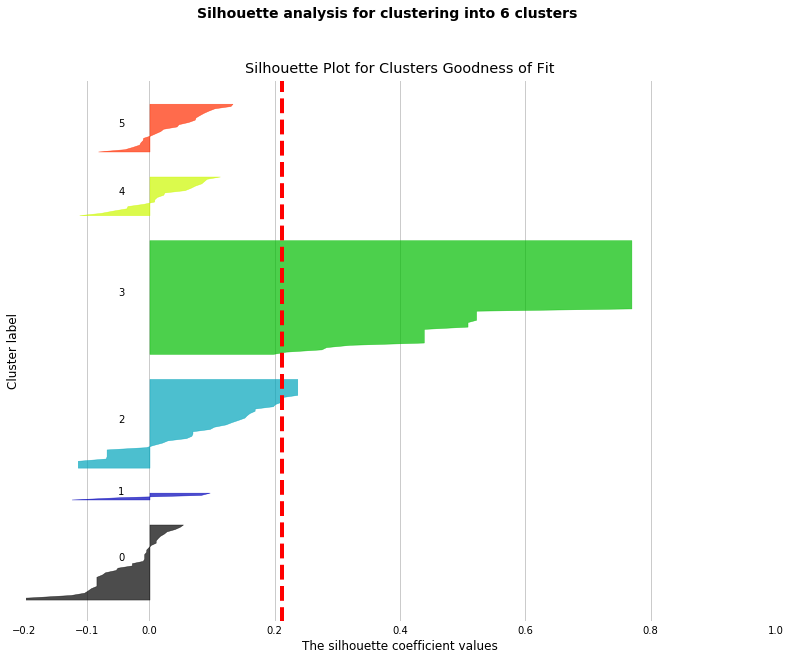

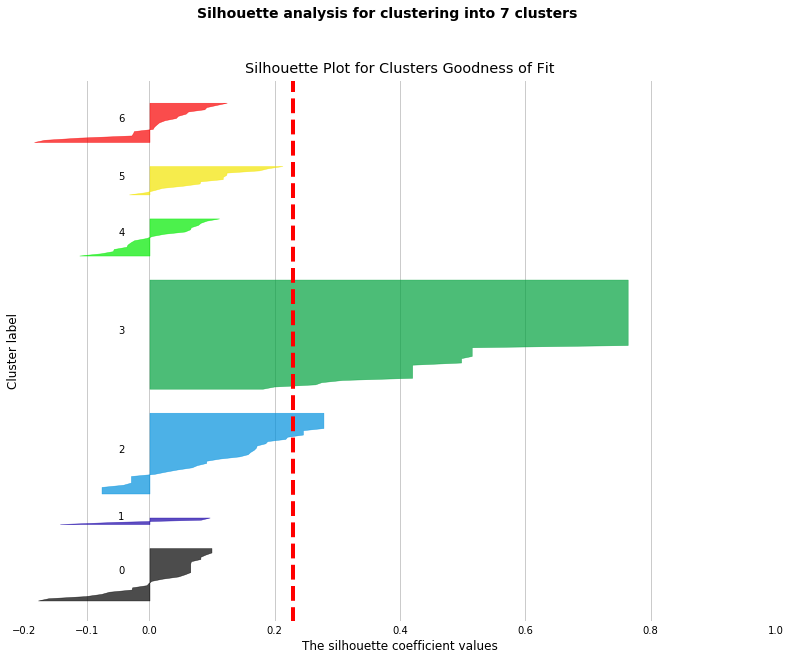

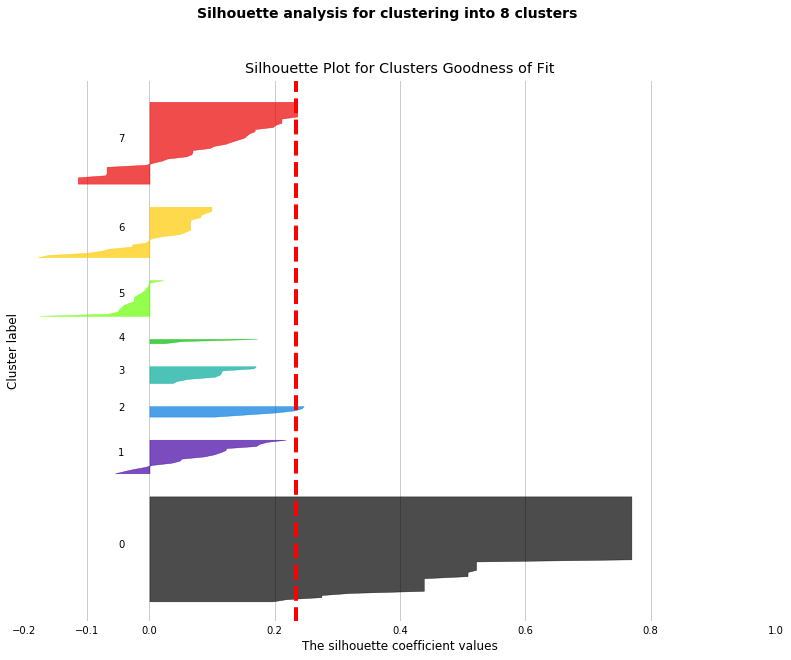

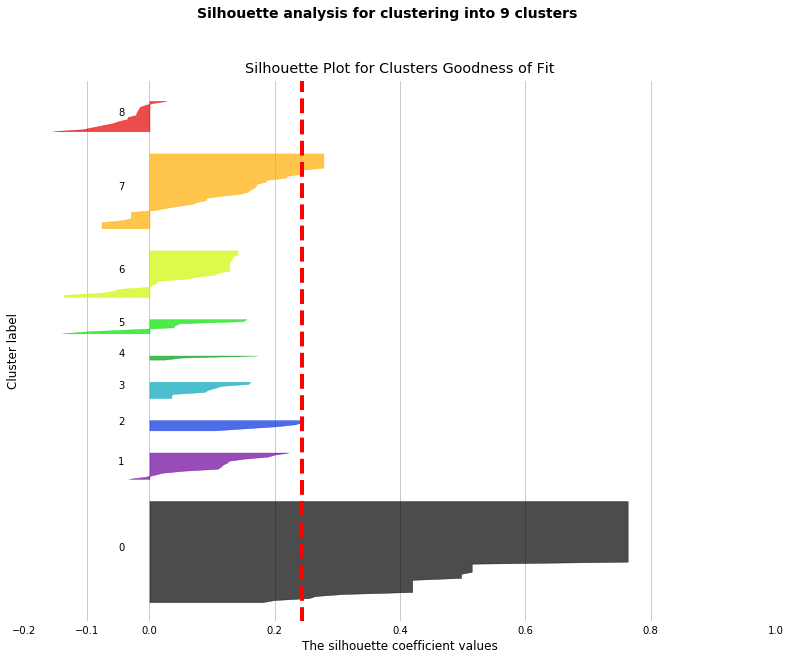

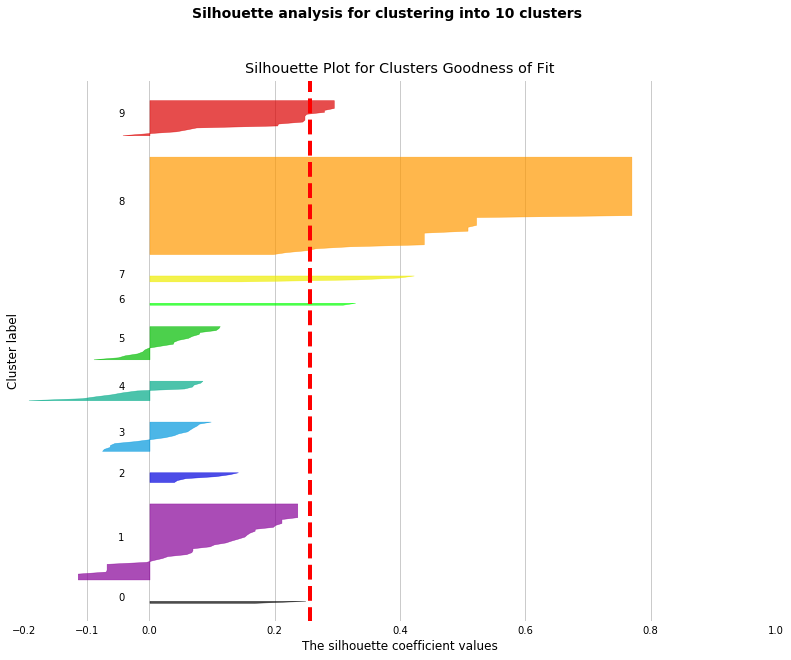

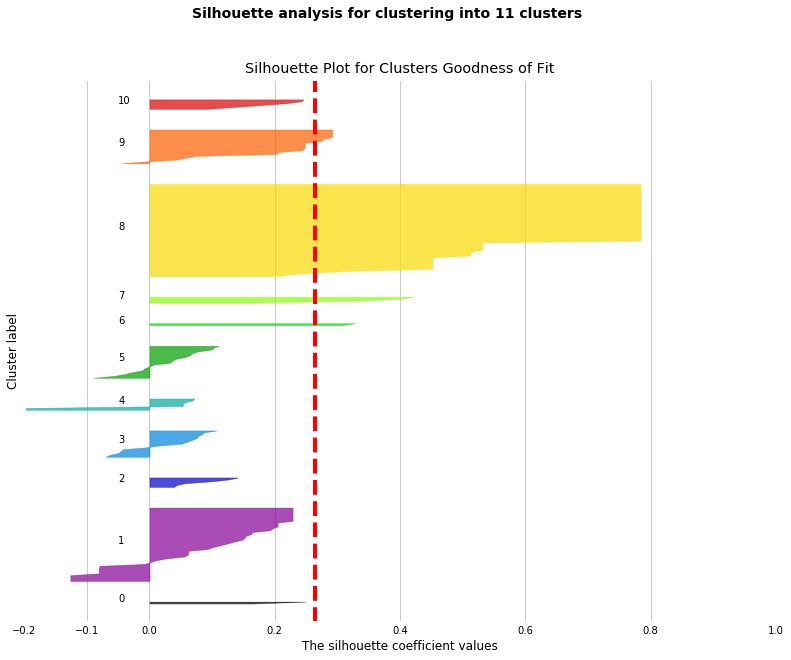

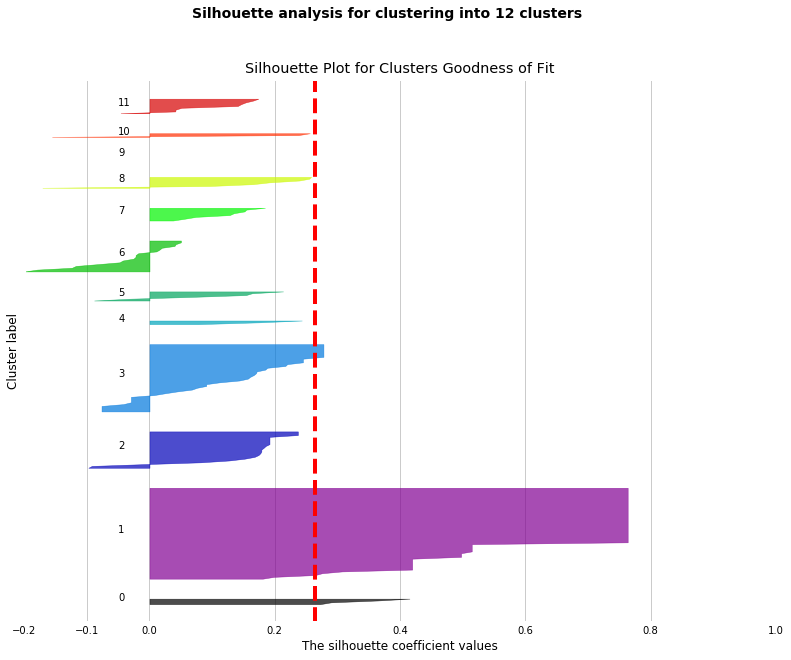

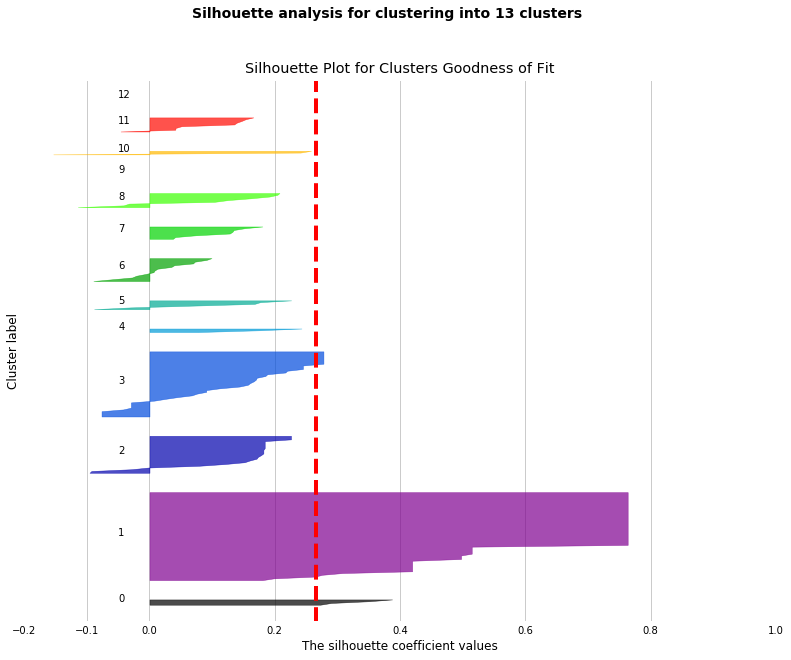

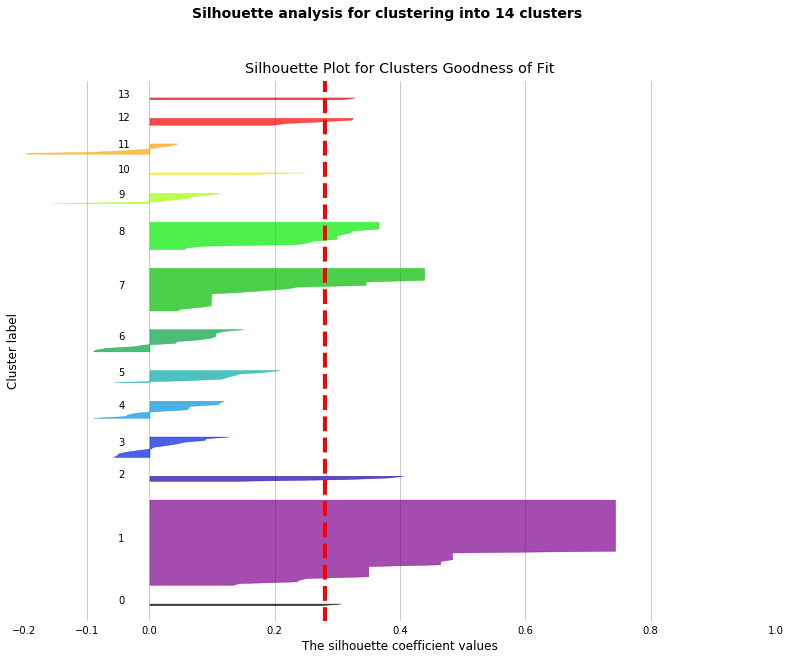

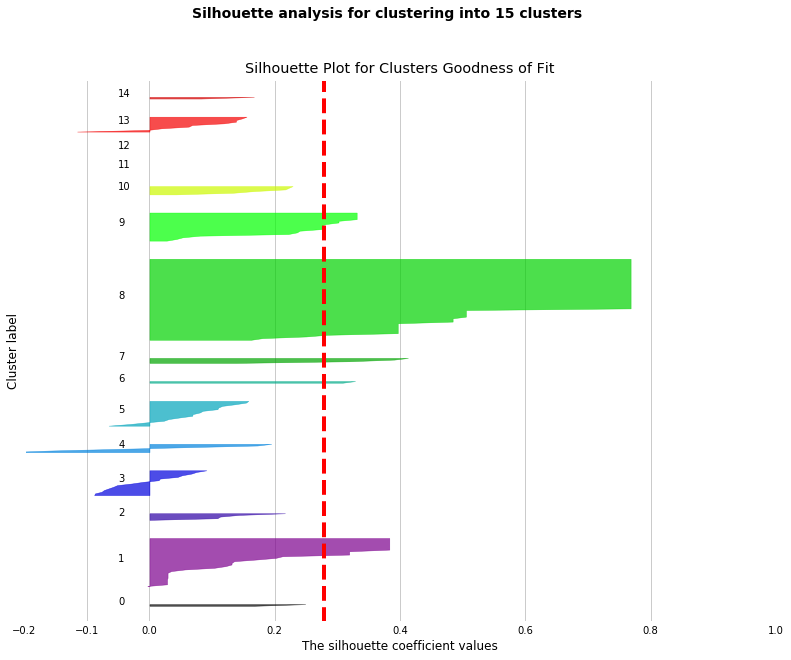

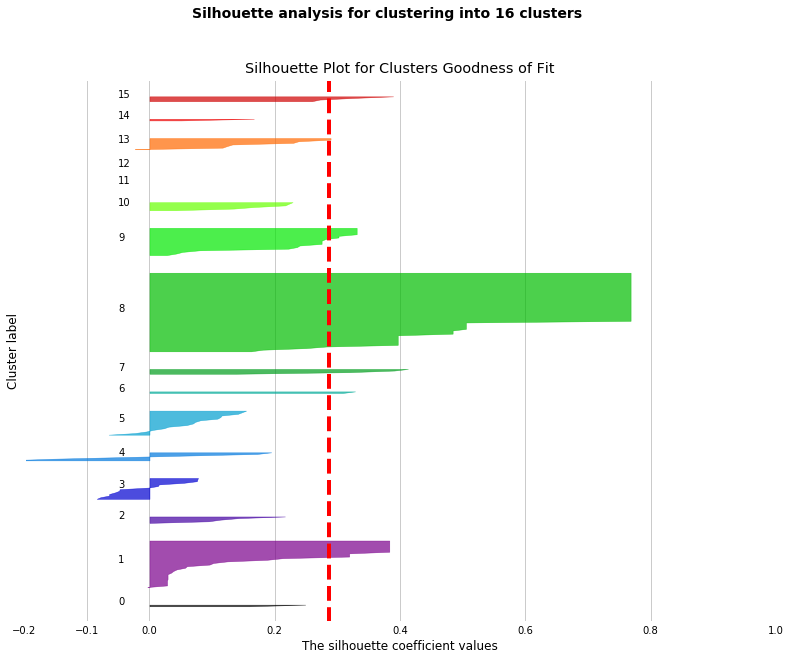

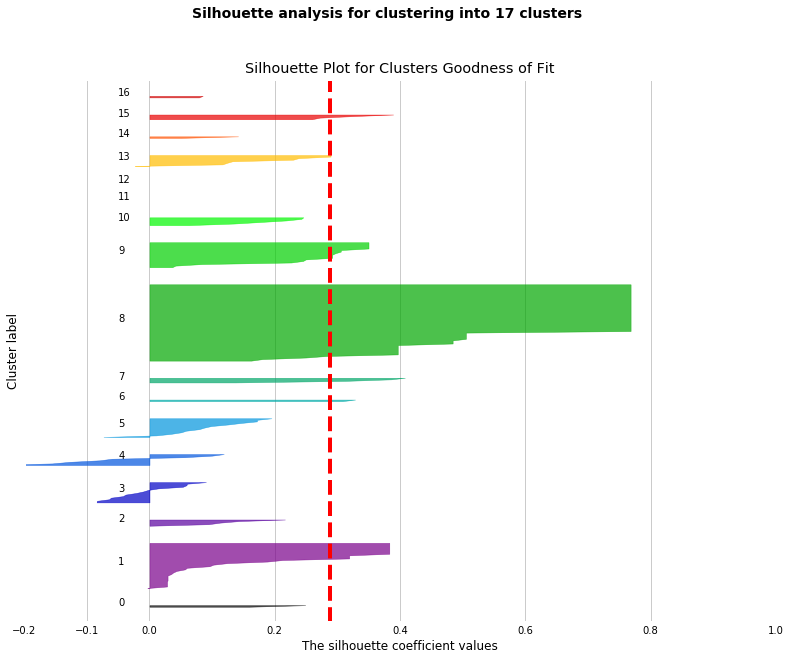

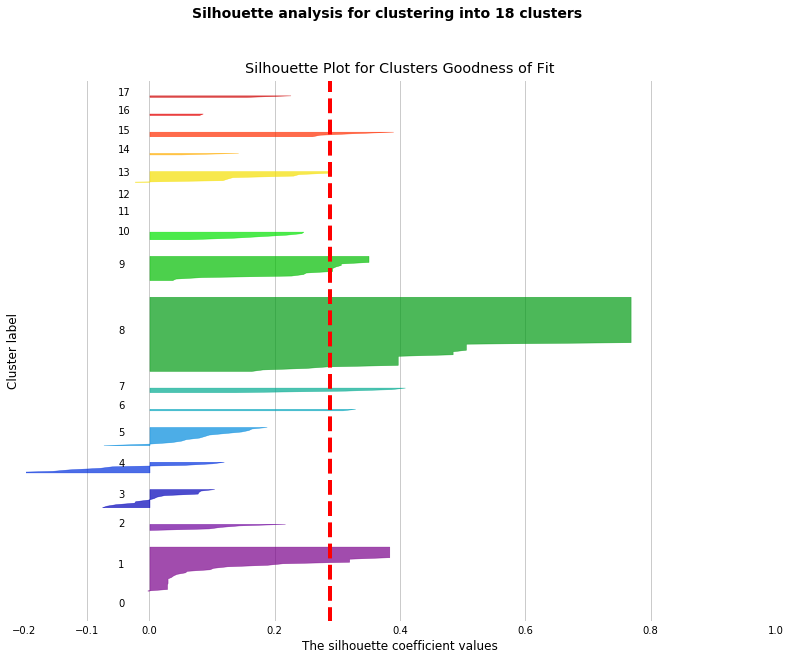

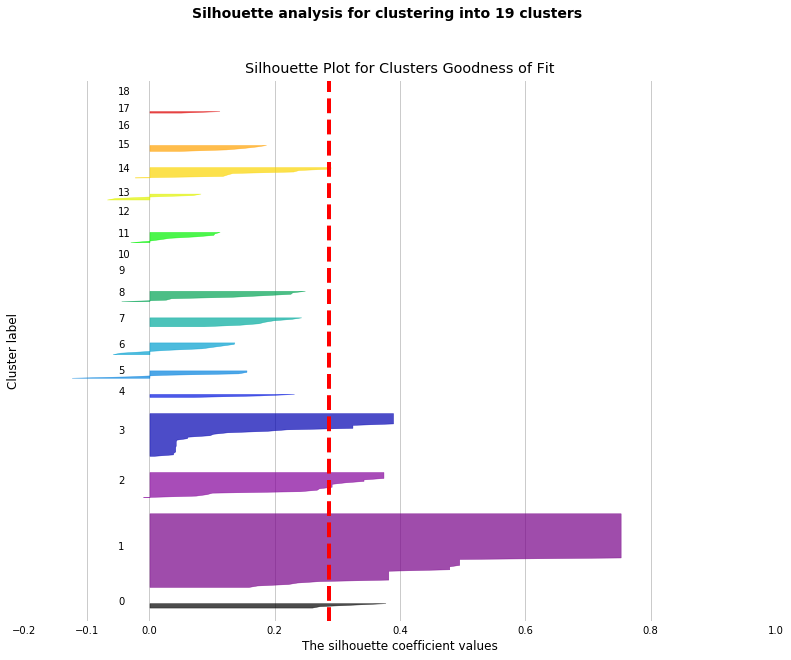

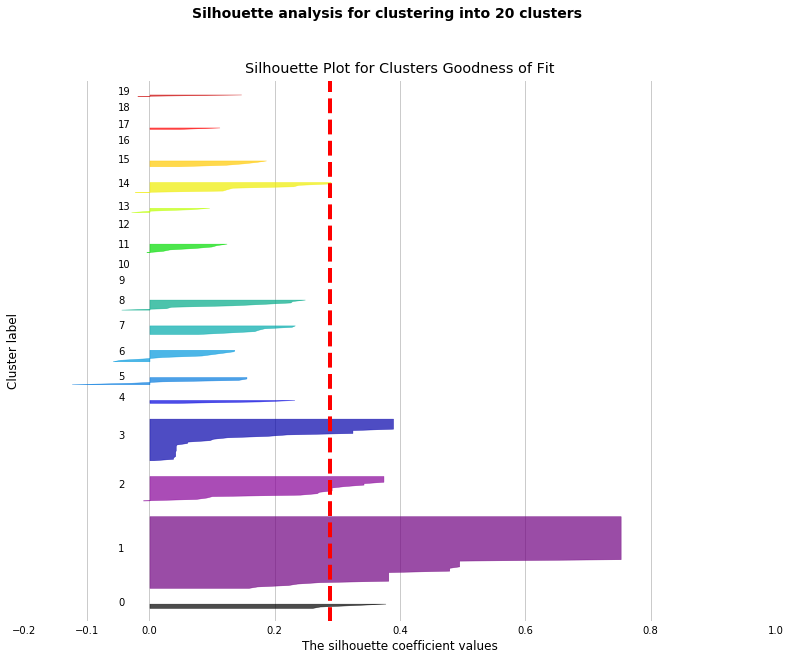

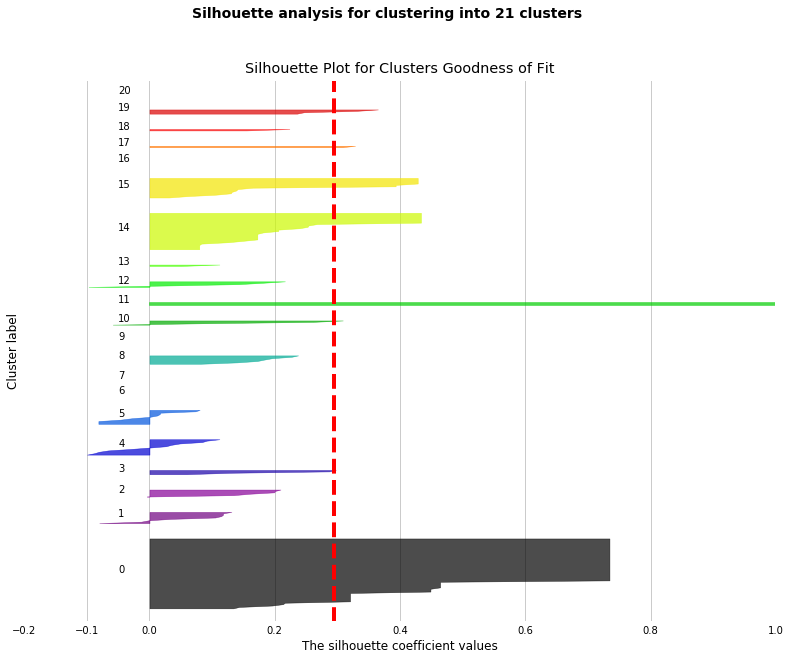

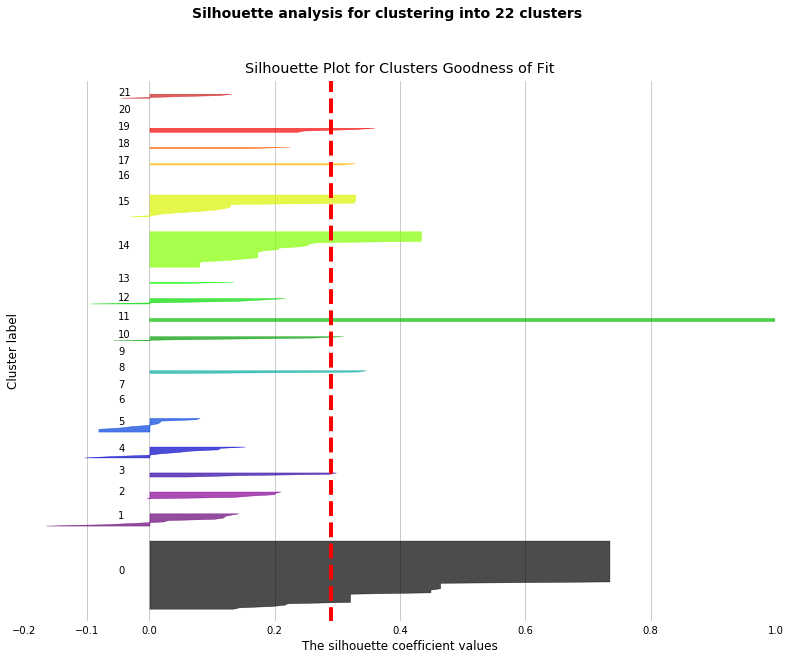

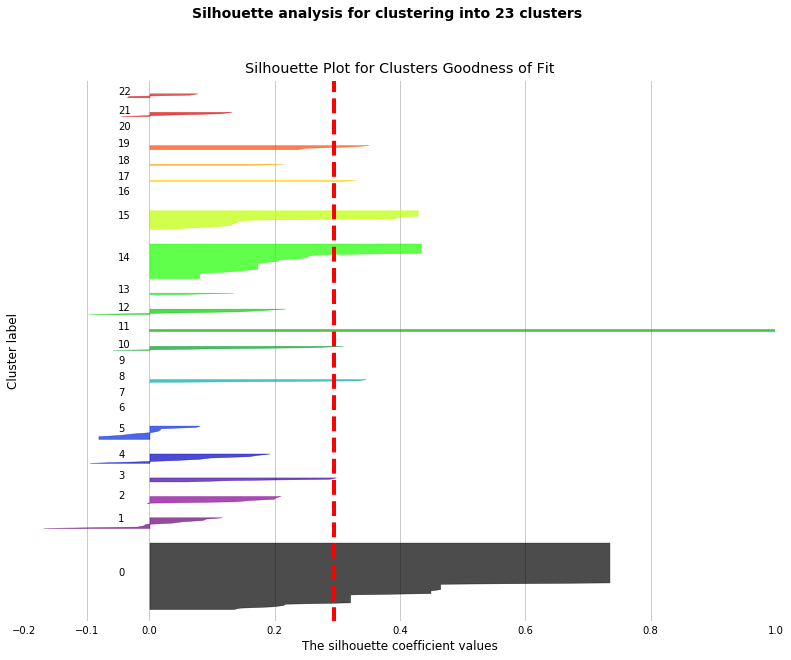

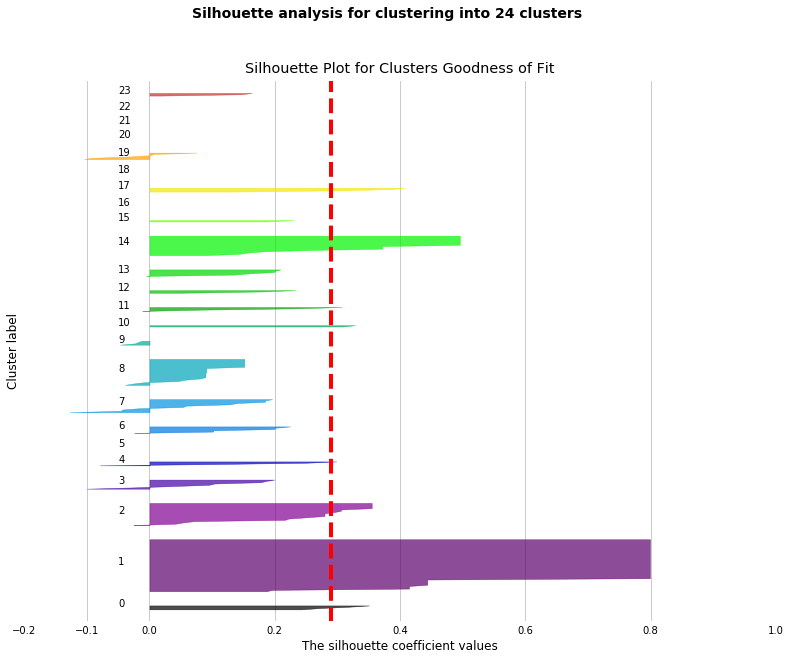

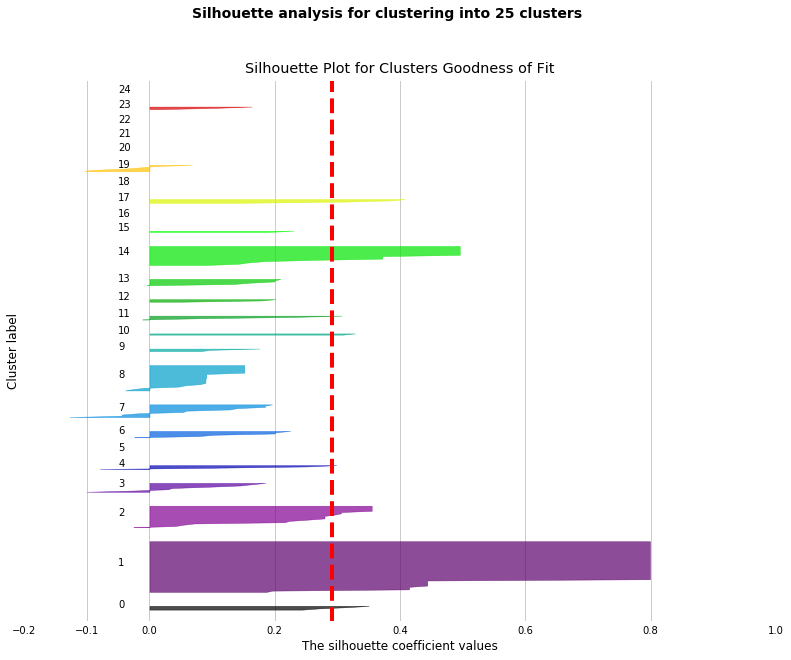

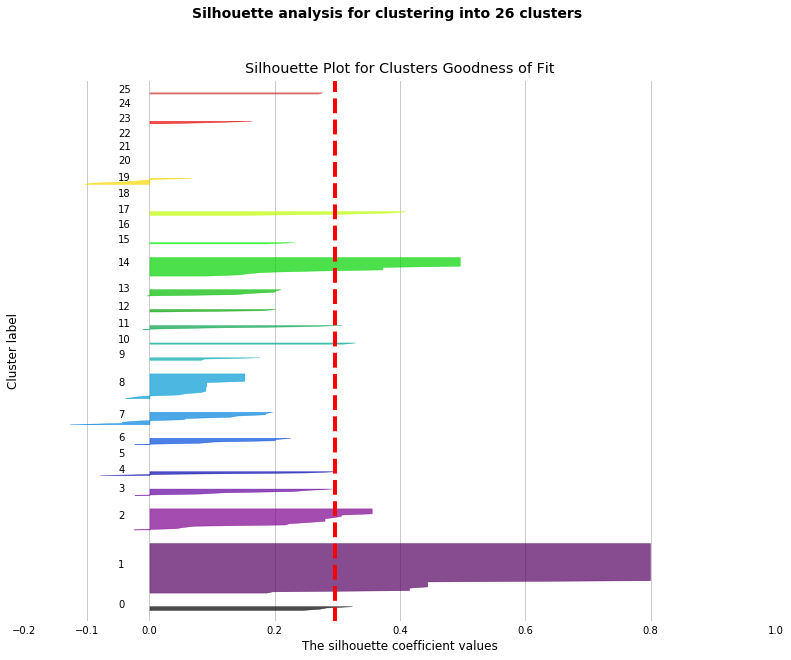

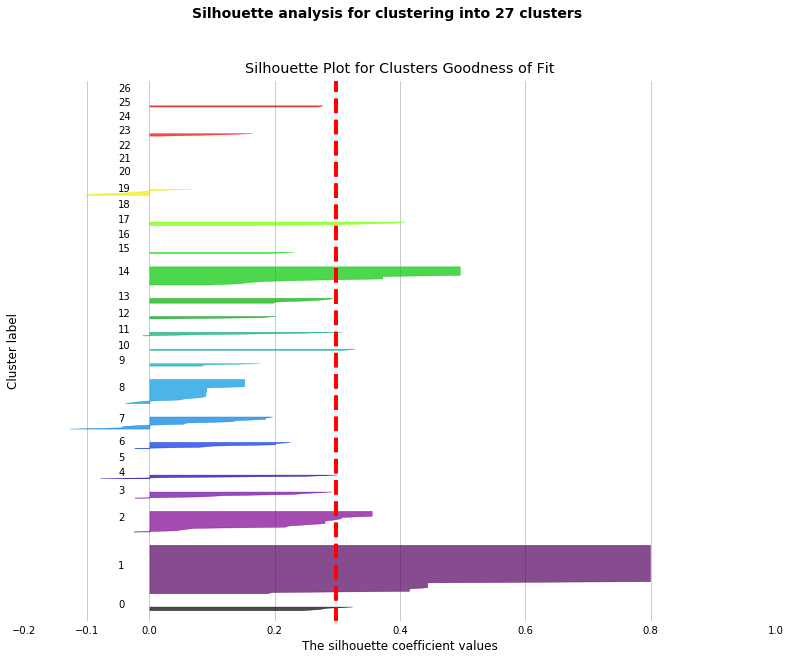

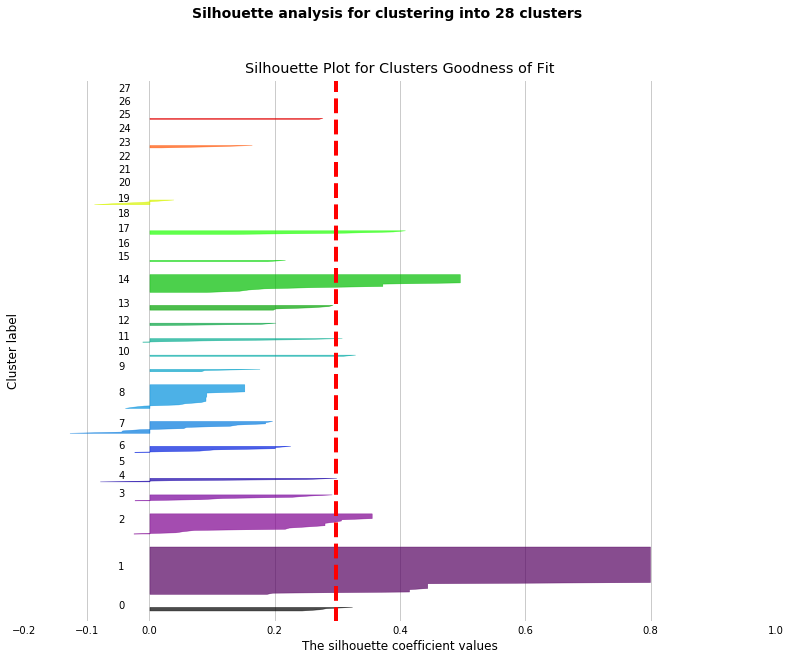

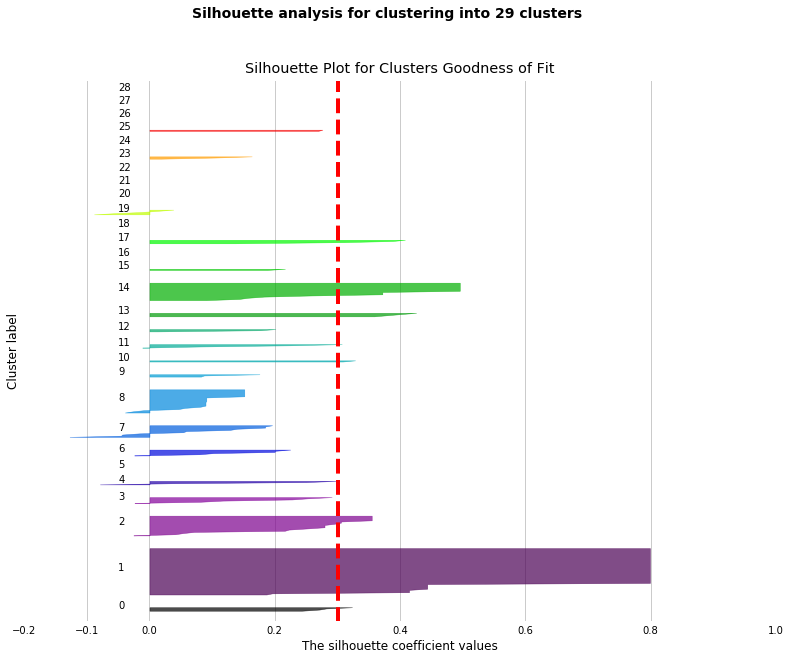

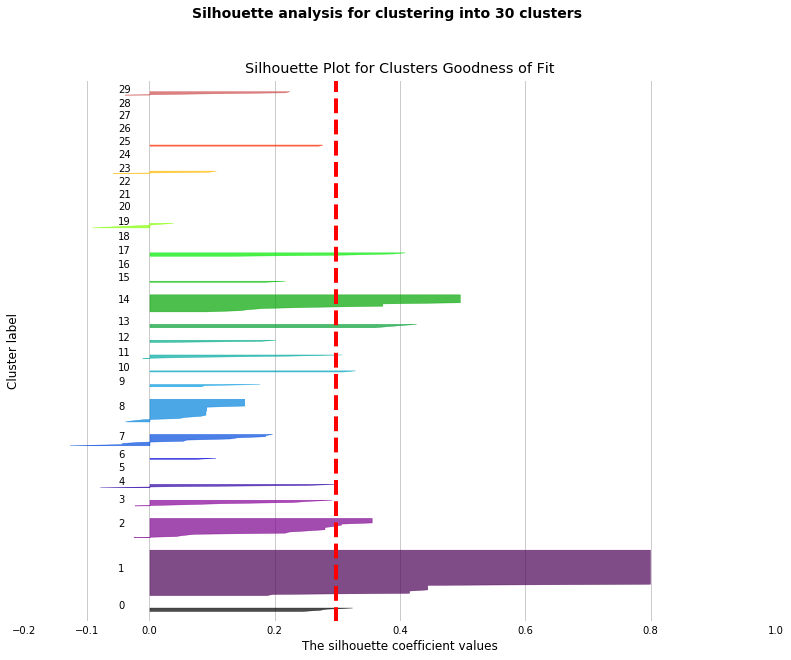

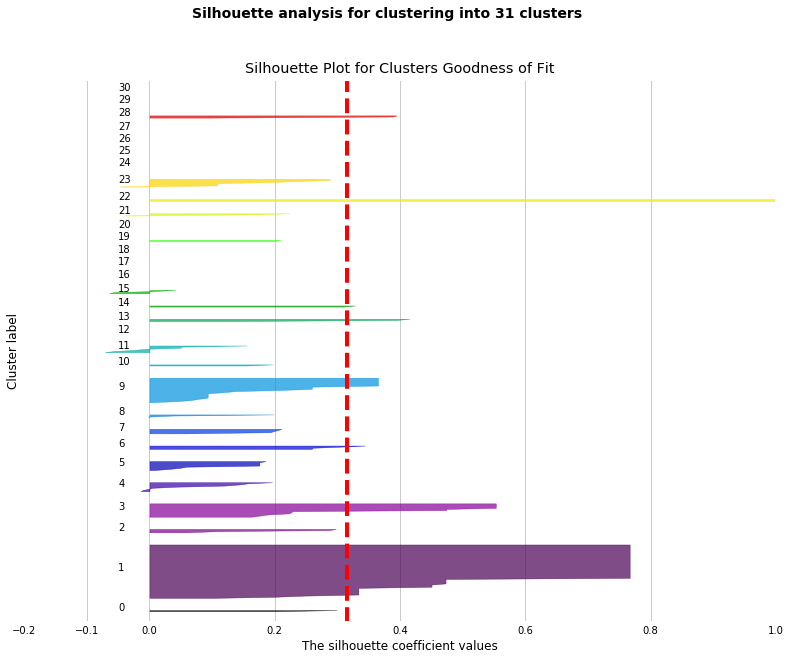

In [21]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import SpectralClustering, DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
import matplotlib.cm as cm

distortions = []
plt.rcParams.update({'figure.max_open_warning': 0})

if exclude_outliers:
    X = X[users.Deviance >= threshold]
else:
    X = base_X.copy()

# Range for number of unique roles to explore the goodness of fit for clustering
K = range(6,32)

display(Markdown('\n## User Clustering to Identify Best Number of Roles'))

display(HTML('<div class="alert alert-block alert-info">'+\
             '<p>There are many possible ways of breaking down the users within a department and defining roles for them '+\
             "without a significant understanding of the department's business processes. This section will take the users "+\
             'within the department and cluster them together into an increasing number of clusters based on the security groups '+\
             'that they are a member of, and their billing code. Billing code was included to attempt to guide the clustering '+\
             'centroids around internal organizational structures.</p> <p>The Silhouette plots provide a visual representation '+\
             'for how tightly matched each user is within their cluster. When a cluster has a tail that spans left of the 0.0 '+\
             'marker, that means it is somewhat dissimilar from the rest of the cluster it is in, and may not be a good fit.</p> '+\
             '</div>'))


display(Markdown("### Metrics for Each Combination of Roles"))
    
for test_val in K:    
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(12, 10)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 42 for reproducibility.
    
    if exclude_outliers:
        clusterer = KMeans(n_clusters=test_val, random_state=42, algorithm="auto")
    else:
        clusterer = KMeans(n_clusters=test_val, random_state=42, algorithm="auto")
        
    cluster_labels = clusterer.fit_predict(X)
    n_clusters = len(np.unique(cluster_labels))
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    calinksi = calinski_harabasz_score(X,cluster_labels)
    silhouette_avg = silhouette_score(X, cluster_labels)
    membership_ac = membership_accuracy(X, cluster_labels)
    print("Number of Roles:", n_clusters,
          #"test_val:", np.round(test_val, 4),
          "MemAcc:", membership_ac[1],
          "Calinksi:", np.round(calinksi, 4), 
          "Silhouette Score:", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in np.unique(cluster_labels):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette Plot for Clusters Goodness of Fit")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)


    plt.suptitle(("Silhouette analysis for clustering "
                  "into {} clusters".format(n_clusters)),
                 fontsize=14, fontweight='bold')

plt.show()

In [23]:
chosen_val = 7

display(Markdown('## Selected Number of Roles: {}'.format(chosen_val)))

clusterer = KMeans(n_clusters=chosen_val, random_state=42, algorithm="auto")
cluster_labels = clusterer.fit_predict(X)
unique_clusters = np.unique(cluster_labels)

## Selected Number of Roles: 7

In [24]:
users['clusters'] = None
if exclude_outliers:
    users.loc[users.Deviance >= threshold, 'clusters'] = cluster_labels
else:
    users['clusters'] = cluster_labels


## Resulting Role Based User Groupings

## Role #0

### Users in Role: 25

,UserName,Title
11,User 12,Role 5
19,User 20,Role 40
39,User 40,Role 23
41,User 42,Role 5
43,User 44,Role 24
44,User 45,Role 25
52,User 53,Role 5
54,User 55,Role 7
59,User 60,Role 5
64,User 65,Role 5


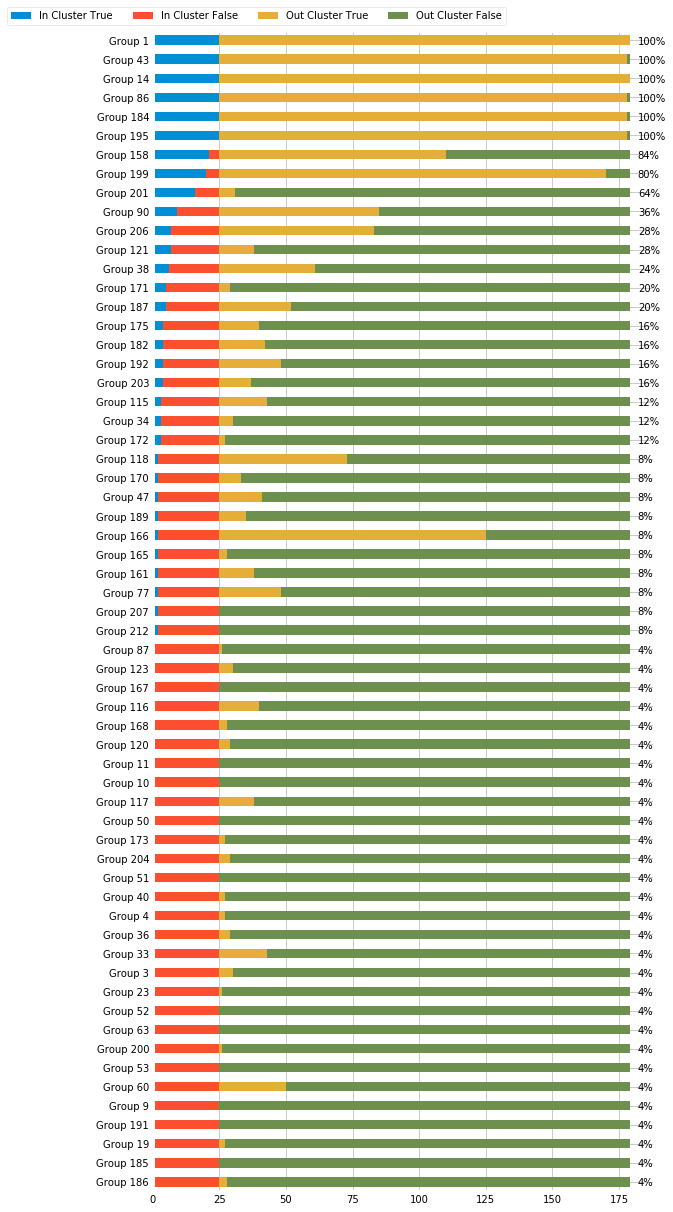

## Role #1

### Users in Role: 4

,UserName,Title
35,User 36,Role 42
57,User 58,Role 55
123,User 124,Role 44
139,User 140,Role 55


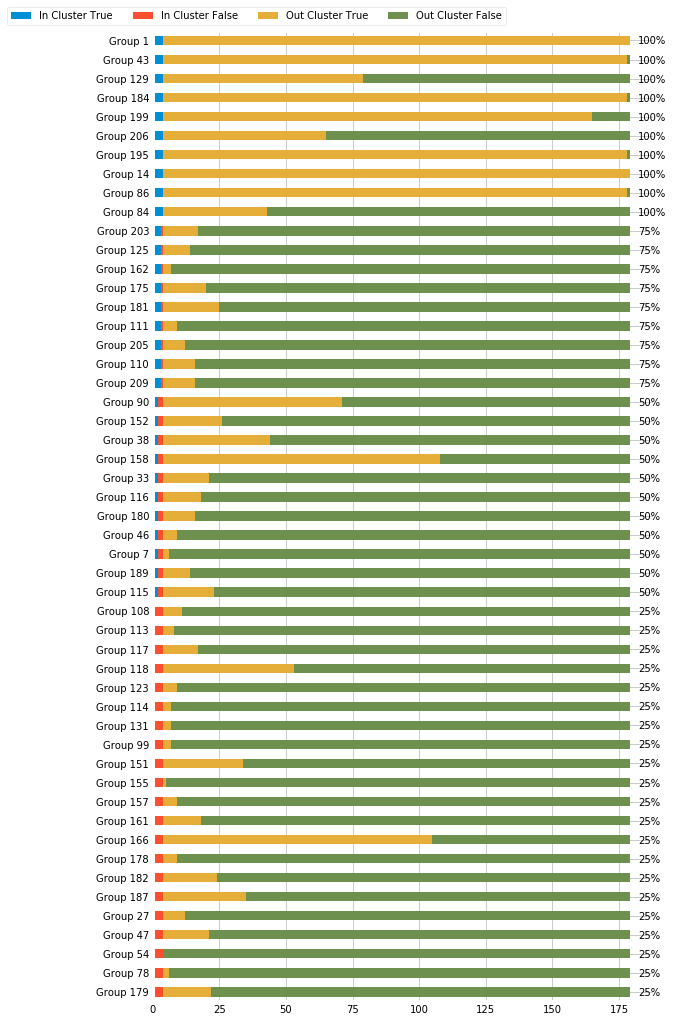

## Role #2

### Users in Role: 38

,UserName,Title
1,User 2,Role 41
5,User 6,Role 39
14,User 15,Role 39
15,User 16,Role 39
17,User 18,Role 39
18,User 19,Role 35
21,User 22,Role 34
30,User 31,Role 60
38,User 39,Role 45
42,User 43,Role 33


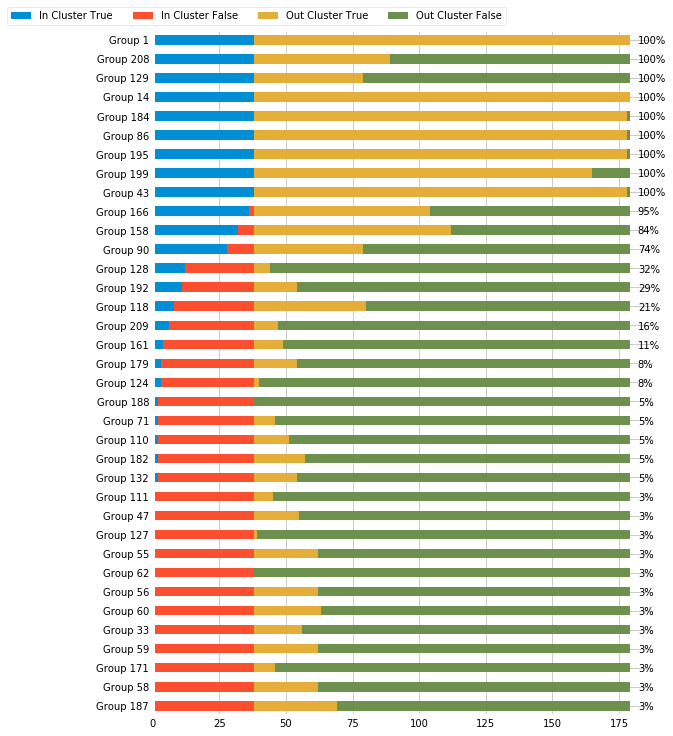

## Role #3

### Users in Role: 51

,UserName,Title
20,User 21,Role 56
31,User 32,Role 39
33,User 34,Role 39
34,User 35,Role 39
37,User 38,Role 52
67,User 68,Role 37
72,User 73,Role 37
73,User 74,Role 15
77,User 78,Role 39
78,User 79,Role 39


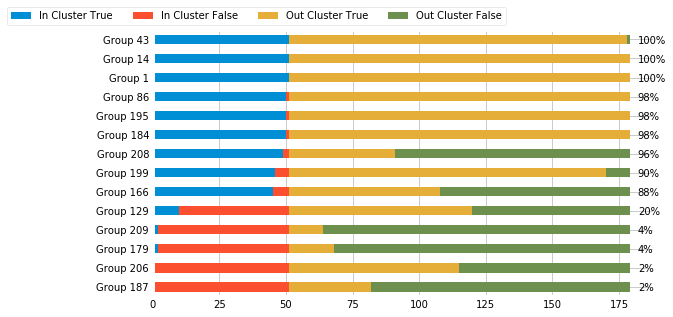

## Role #4

### Users in Role: 18

,UserName,Title
3,User 4,Role 13
6,User 7,Role 55
9,User 10,Role 13
16,User 17,Role 50
23,User 24,Role 56
24,User 25,Role 57
29,User 30,Role 50
36,User 37,Role 66
49,User 50,Role 50
69,User 70,Role 13


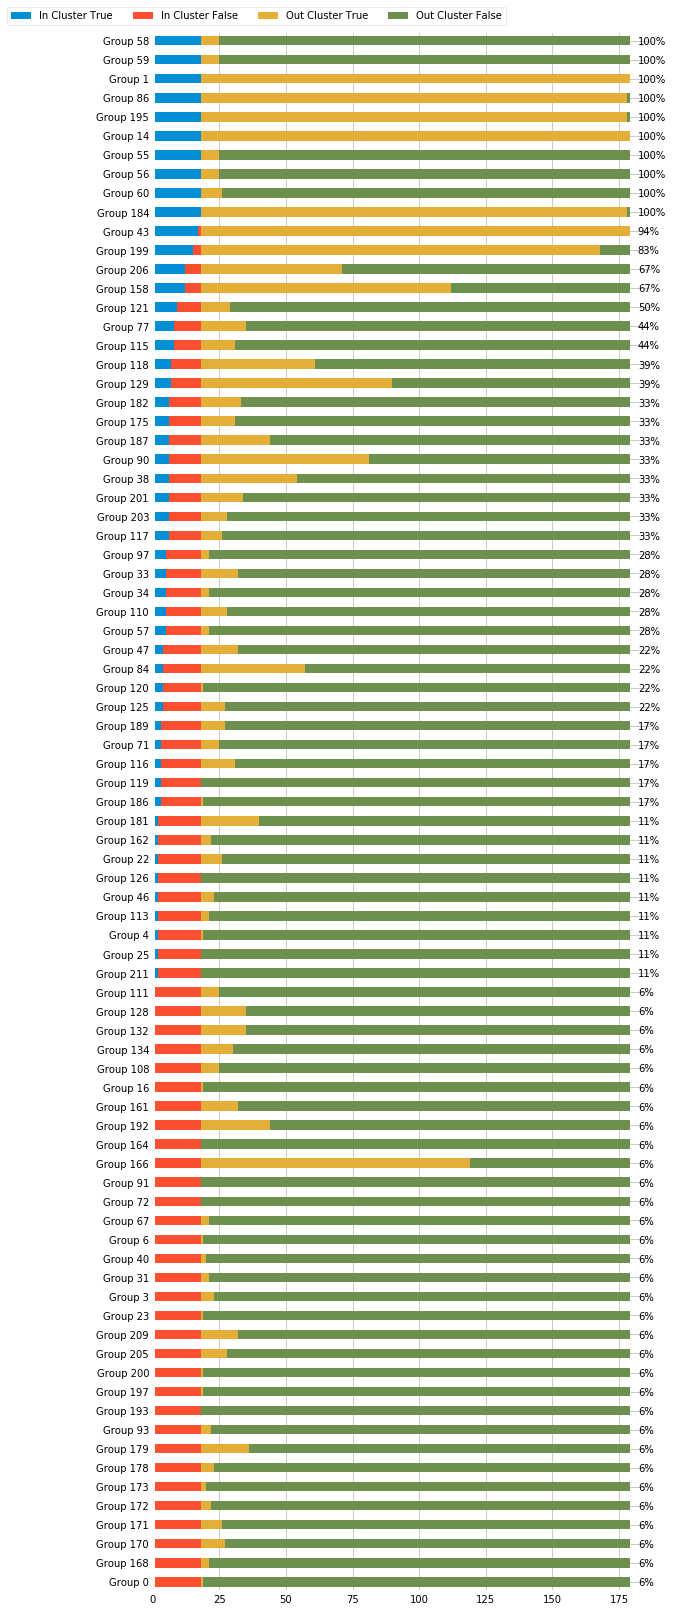

## Role #5

### Users in Role: 14

,UserName,Title
7,User 8,Role 23
26,User 27,Role 53
27,User 28,Role 30
46,User 47,Role 24
48,User 49,Role 22
51,User 52,Role 18
56,User 57,Role 18
70,User 71,Role 54
87,User 88,Role 19
100,User 101,Role 53


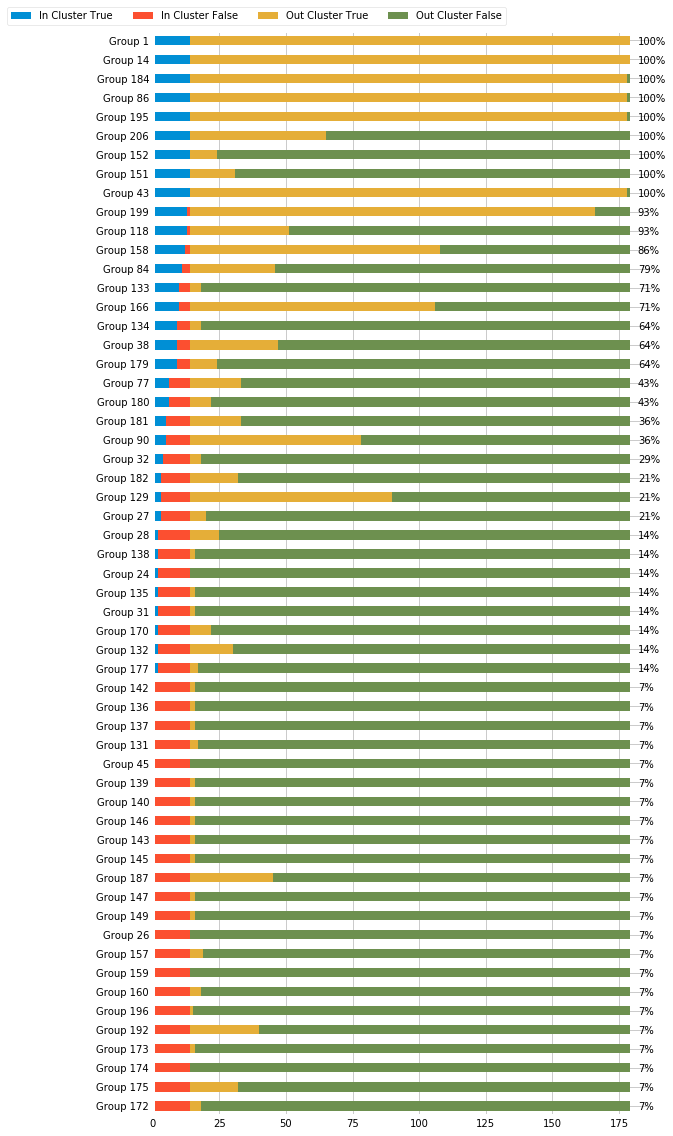

## Role #6

### Users in Role: 19

,UserName,Title
2,User 3,Role 23
4,User 5,Role 25
10,User 11,Role 53
12,User 13,Role 28
13,User 14,Role 62
25,User 26,Role 48
28,User 29,Role 24
32,User 33,Role 18
40,User 41,Role 62
47,User 48,Role 25


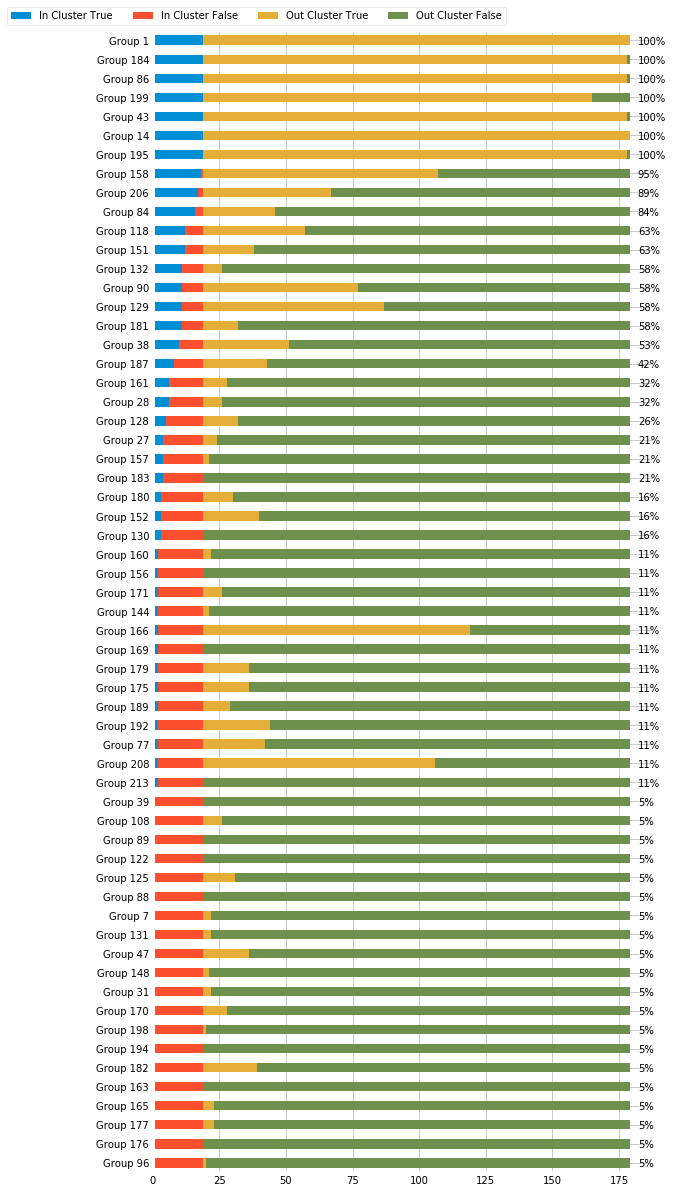

In [25]:
display(Markdown('\n## Resulting Role Based User Groupings'))

display(HTML('<div class="alert alert-block alert-info"><ul>'+\
             '<li>The graphs below show the distribution of membership for the security groups that are present '+\
             'among the users that were clustered together. The percentage on the right side of each horizontal bar represents '+\
             'the percentage of membership for that security group for the members of that role that were clustered together.</li>'+\
             '<li>A threshold needs to be identified for the minimum percentage of within group membership of a security group '+\
             'for that security group to be included in the baseline profile for the role that it is clustered with. '+\
             '</li></ul>'+\
             '</div>'))

for cluster in unique_clusters:
    cluster_populated_columns = group_cols[users[(users.clusters == cluster)][group_cols].mean() > 0]
    
    group_dist = users.groupby(users.clusters==cluster)[cluster_populated_columns].sum().transpose()
    group_size = len(users[users.clusters==cluster])
    outgroup_size = len(users[users.clusters!=cluster])
    group_stats = pd.DataFrame()
    
    group_stats['In Cluster True'] = group_dist[True]
    group_stats['In Cluster False'] = group_size - group_dist[True]
    group_stats['Out Cluster True'] = group_dist[False]
    group_stats['Out Cluster False'] = outgroup_size - group_dist[False]
    
    display(Markdown('## Role #{}'.format(cluster)))
    display(Markdown('### Users in Role: {}'.format(group_size)))
    display(users[(users.clusters == cluster)][['UserName', 'Title']])
    
    plot_size = len(cluster_populated_columns)
    group_stats = group_stats.sort_values('In Cluster True')
    ax = group_stats.plot.barh(stacked=True, figsize=(8,plot_size*0.35), legend=False)
    patches, labels = ax.get_legend_handles_labels()
    legend = ax.legend(patches, labels, bbox_to_anchor=(-0.3, 1.001, 0.9, .102), loc=3, fancybox=True, ncol=4)
    
    for i, val in enumerate(group_stats['In Cluster True']):
        ax.text(group_size+outgroup_size+3, i-0.2, "{0:.0%}".format(float(val/group_size)))
    
    plt.show()

In [26]:
group_threshold = 0.6

display(Markdown('## Within Group Membership Percentage Threshold: {}'.format(group_threshold)))

for cluster in unique_clusters:
    selected_columns = group_cols[users[(users.clusters == cluster)][group_cols].mean() > group_threshold]
    display(Markdown('### Role #{} Base Security Groups'.format(cluster)))
    print("\n".join(selected_columns))

## Within Group Membership Percentage Threshold: 0.6

### Role #0 Base Security Groups

Group 1
Group 14
Group 158
Group 184
Group 195
Group 199
Group 201
Group 43
Group 86


### Role #1 Base Security Groups

Group 1
Group 110
Group 111
Group 125
Group 129
Group 14
Group 162
Group 175
Group 181
Group 184
Group 195
Group 199
Group 203
Group 205
Group 206
Group 209
Group 43
Group 84
Group 86


### Role #2 Base Security Groups

Group 1
Group 129
Group 14
Group 158
Group 166
Group 184
Group 195
Group 199
Group 208
Group 43
Group 86
Group 90


### Role #3 Base Security Groups

Group 1
Group 14
Group 166
Group 184
Group 195
Group 199
Group 208
Group 43
Group 86


### Role #4 Base Security Groups

Group 1
Group 14
Group 158
Group 184
Group 195
Group 199
Group 206
Group 43
Group 55
Group 56
Group 58
Group 59
Group 60
Group 86


### Role #5 Base Security Groups

Group 1
Group 118
Group 133
Group 134
Group 14
Group 151
Group 152
Group 158
Group 166
Group 179
Group 184
Group 195
Group 199
Group 206
Group 38
Group 43
Group 84
Group 86


### Role #6 Base Security Groups

Group 1
Group 118
Group 14
Group 151
Group 158
Group 184
Group 195
Group 199
Group 206
Group 43
Group 84
Group 86
